In [1]:
#Download Dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import glob
import os
# import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.applications.resnet import preprocess_input

In [2]:
%pwd

'd:\\mjourFinalPorject\\research'

In [3]:
os.chdir("D://mjourFinalPorject//artifacts//data_ingestion//dcdata")

In [4]:
%pwd

'D:\\mjourFinalPorject\\artifacts\\data_ingestion\\dcdata'

In [5]:
#instantiate the constants
batch_size = 16
img_size = 224
epochs = 10

In [6]:
print(len(os.listdir('D://mjourFinalPorject//artifacts//data_ingestion//dcdata//train')), "training data")
print(len(os.listdir('D://mjourFinalPorject//artifacts//data_ingestion//dcdata//test')), "test data")


4801 training data
2400 test data


In [7]:
def gen_label(directory):
    label = []
    for file in os.listdir(directory):
        if (file.split('.')[0] == 'dog'):
            label.append(str(1))
        elif (file.split('.')[0] == 'cat'):
            label.append(str(0))
    return label
    #print(len(label),"files in", directory)
    
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path

train_y = gen_label('train')
train_x = get_path('train')
test_x = get_path('test')

In [8]:
import pandas as pd

df = pd.DataFrame({'filename': train_x,
                  'category': train_y})
print(df.head())

sns.countplot(x='category',data=df).set_title("Data Distribution")

ValueError: All arrays must be of the same length

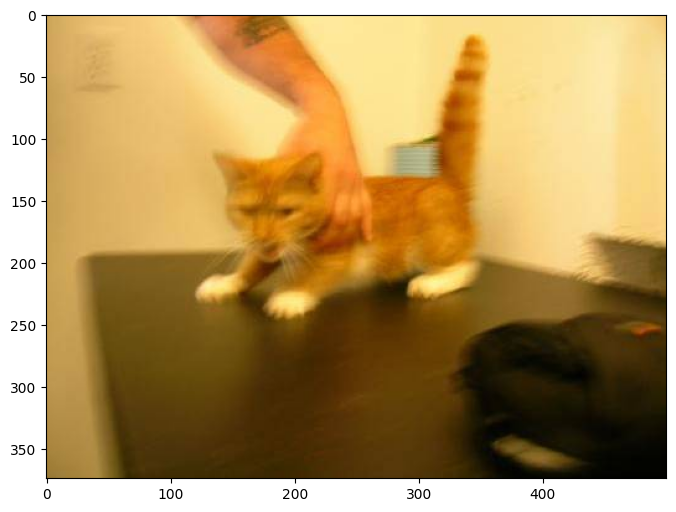

In [9]:
# Change working directory
os.chdir('train')

img = load_img(df['filename'].iloc[0]) 
  
# Displaying the image 
plt.figure(figsize=(8,8))
plt.imshow(img)

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils.vis_utils import plot_model

# Define the model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Input shape is typically (height, width, channels)
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')  # Assuming binary classification for dogs vs. cats
])

# Generate a plot of the model architecture
plot_image_path = "model_architecture.png"
plot_model(model, to_file=plot_image_path, show_shapes=True, show_layer_names=True)

print(f"Model architecture image saved to {plot_image_path}")


AttributeError: module 'pydot' has no attribute 'InvocationException'

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.25)
print(train_df.shape)
print(valid_df.shape)

(18750, 2)
(6250, 2)


In [11]:
def generate_train_batch(model):
    
    if model == 'resnet':      #use of resnet requires its specific preprocessing_function for better accuracy for augmentation
        print('resnet data')
        train_datagen = ImageDataGenerator(
                    rotation_range=10,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    preprocessing_function = preprocess_input)

    else:
        train_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1)

    if model == 'vgg':   #VGG16 will only generate mini-batches of x_features; y_col=None as feature extractor
        print('vgg data')
        train_gen = train_datagen.flow_from_dataframe(
            train_df[['filename']],
            x_col='filename',
            y_col=None,
            target_size=(img_size, img_size),
            batch_size = batch_size,
            class_mode=None,
            shuffle=False)
        
    else:
        train_gen = train_datagen.flow_from_dataframe(
                    train_df,
                    x_col='filename',
                    y_col='category',
                    target_size=(img_size, img_size),
                    batch_size = batch_size,
                    class_mode='binary')

    return train_gen


def generate_valid_batch(model):
    if model == 'resnet':
        print('resnet validation set')
        valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
    else:
        valid_datagen = ImageDataGenerator(rescale=1./255)
        
    valid_gen = valid_datagen.flow_from_dataframe(
            valid_df,
            x_col='filename',
            y_col='category',
            target_size=(img_size, img_size),
            batch_size = batch_size,
            class_mode='binary')
    
    return valid_gen

train_gen = generate_train_batch('others')
valid_gen = generate_valid_batch('others')

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


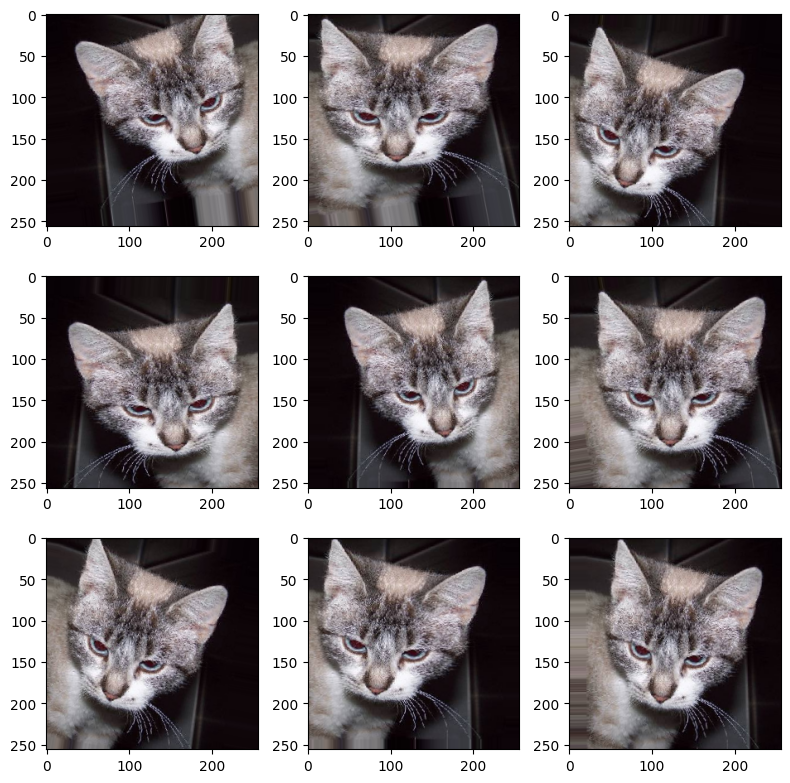

In [12]:
visual_datagen = ImageDataGenerator(    #standard augmentation
                    rotation_range=10,
                    rescale=1./255,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    width_shift_range=0.1,
                    height_shift_range=0.1)

visualise_df = train_df.sample(n=1).reset_index(drop=True)
visualisation_generator = visual_datagen.flow_from_dataframe(
    visualise_df,  
    x_col='filename',
    y_col='category'
)
plt.figure(figsize=(8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in visualisation_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [13]:
from keras.applications import VGG16, resnet
from keras.layers import *
from keras.models import Model,Sequential
from keras import optimizers
from keras import regularizers

In [14]:
from keras import backend as K
K.clear_session()

In [15]:
#model instantiation
modelcnn=Sequential()
modelcnn.add(Conv2D(16, (3,3), activation="relu", input_shape=(img_size, img_size, 3)))
modelcnn.add(Conv2D(16, (3,3), activation="relu",))
modelcnn.add(MaxPooling2D((3,3)))

modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D(2,2))

modelcnn.add(Conv2D(64, (3,3), activation="relu"))
modelcnn.add(Conv2D(64, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D(2,2))
modelcnn.add(Dropout(0.3))

modelcnn.add(Conv2D(32, (3,3), activation="relu"))
modelcnn.add(MaxPooling2D((2,2)))

modelcnn.add(Flatten())
modelcnn.add(Dense(512, activation="relu"))
modelcnn.add(Dropout(0.5))
modelcnn.add(Dense(1, activation="sigmoid"))

modelcnn.compile(loss="binary_crossentropy", 
         optimizer=optimizers.RMSprop(lr=1e-4),
         metrics=["accuracy"])

d:\mjourfinalporject\mf\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
modelcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                    

In [17]:
history = modelcnn.fit_generator(train_gen,
                    epochs=epochs,
                    validation_data=valid_gen)

C:\Users\dongr\AppData\Local\Temp\ipykernel_4840\3236308057.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelcnn.fit_generator(train_gen,


Epoch 1/10
1172/1172 [==============================] - 275s 227ms/step - loss: 0.6652 - accuracy: 0.5808 - val_loss: 0.5993 - val_accuracy: 0.6758
Epoch 2/10
1172/1172 [==============================] - 178s 152ms/step - loss: 0.5908 - accuracy: 0.6815 - val_loss: 0.5495 - val_accuracy: 0.7213
Epoch 3/10
1172/1172 [==============================] - 180s 153ms/step - loss: 0.5594 - accuracy: 0.7102 - val_loss: 0.5450 - val_accuracy: 0.7234
Epoch 4/10
1172/1172 [==============================] - 180s 153ms/step - loss: 0.5403 - accuracy: 0.7251 - val_loss: 0.5111 - val_accuracy: 0.7573
Epoch 5/10
1172/1172 [==============================] - 180s 153ms/step - loss: 0.5260 - accuracy: 0.7373 - val_loss: 0.6243 - val_accuracy: 0.6755
Epoch 6/10
1172/1172 [==============================] - 178s 152ms/step - loss: 0.5133 - accuracy: 0.7472 - val_loss: 0.4868 - val_accuracy: 0.7693
Epoch 7/10
1172/1172 [==============================] - 179s 153ms/step - loss: 0.4976 - accuracy: 0.7585 - val_

In [18]:
loss, accuracy = modelcnn.evaluate_generator(valid_gen, valid_gen.samples//batch_size, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

C:\Users\dongr\AppData\Local\Temp\ipykernel_4840\1399065358.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = modelcnn.evaluate_generator(valid_gen, valid_gen.samples//batch_size, workers=12)


Validation: accuracy = 0.807051  ;  loss = 0.415768 


In [19]:
modelcnn.save('D:/mjourFinalPorject/artifacts/training/cnnmodel.h5')
modelcnn.save_weights('D:/mjourFinalPorject/artifacts/training/cnnweights.h5')
modelcnn.load_weights('D:/mjourFinalPorject/artifacts/training/cnnweights.h5')

In [20]:
hist_df = pd.DataFrame(history.history)
print(hist_df)

       loss  accuracy  val_loss  val_accuracy
0  0.665246  0.580800  0.599340       0.67584
1  0.590807  0.681493  0.549462       0.72128
2  0.559423  0.710240  0.545003       0.72336
3  0.540271  0.725067  0.511077       0.75728
4  0.525953  0.737333  0.624309       0.67552
5  0.513317  0.747200  0.486818       0.76928
6  0.497637  0.758453  0.510986       0.75104
7  0.479867  0.770773  0.455974       0.78320
8  0.463878  0.780533  0.419517       0.80624
9  0.445397  0.792960  0.415519       0.80720


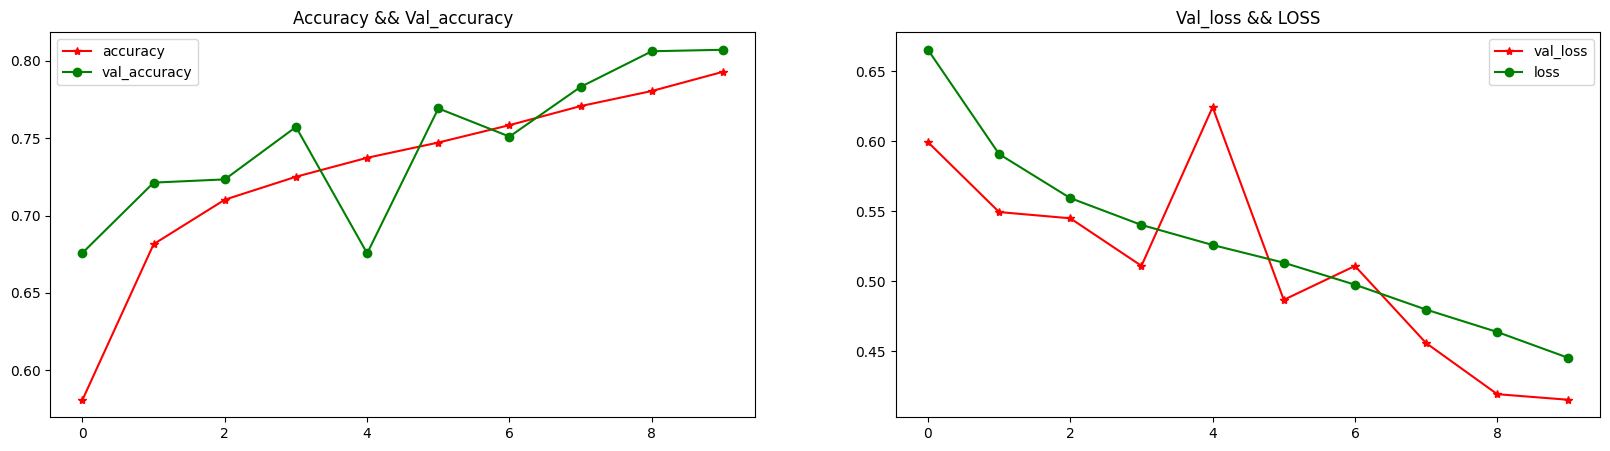

In [21]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(hist_df['accuracy'],marker='*',c='r',label='accuracy')
plt.plot(hist_df['val_accuracy'],marker='o',c='g',label='val_accuracy')
plt.title('Accuracy && Val_accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_df['val_loss'],marker='*',c='r',label='val_loss')
plt.plot(hist_df['loss'],marker='o',c='g',label='loss')
plt.title('Val_loss && LOSS')
plt.legend()